In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
directory1 = "/content/drive/MyDrive/Emotion Classifiers (ResNets)/data/train"
directory2 = "/content/drive/MyDrive/Emotion Classifiers (ResNets)/data/val"

train_datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, rescale=1./255)
train_dataset = train_datagen.flow_from_directory(directory1, 
                                                  target_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True)
                                                
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_dataset = validation_datagen.flow_from_directory(directory2, 
                                                          target_size = IMG_SIZE,
                                                          batch_size = BATCH_SIZE,
                                                          shuffle = True)

Found 2659 images belonging to 6 classes.
Found 2658 images belonging to 6 classes.


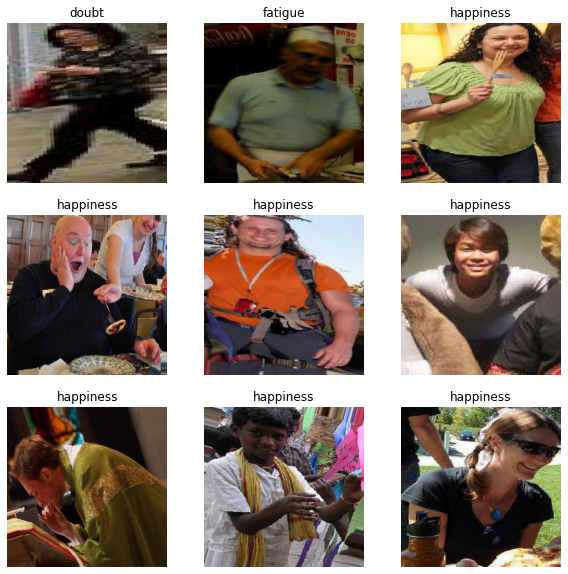

In [5]:
class_name = list(train_dataset.class_indices.keys())

plt.figure(figsize=(10, 10))

for i in range(9):
    image, label = train_dataset.next()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(class_name[tf.argmax(label[0])])
    plt.axis("off")

In [6]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, constant, identity

In [7]:
# Identity Block
def identity_block(X, f, filters, training=True, initializer=RandomUniform):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X  

In [8]:
# Convolutional Block
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer)(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape=(256, 256, 3), classes=6):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform)(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform)(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [10]:
model = ResNet50(input_shape = (256, 256, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
import os
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs = 10)

Epoch 1/10
84/84 [==============================] - 1103s 13s/step - loss: 5.7327 - accuracy: 0.4757 - val_loss: 1.4353 - val_accuracy: 0.8202
Epoch 2/10
84/84 [==============================] - 101s 1s/step - loss: 2.8440 - accuracy: 0.5664 - val_loss: 1.2591 - val_accuracy: 0.8126
Epoch 3/10
84/84 [==============================] - 100s 1s/step - loss: 1.7478 - accuracy: 0.5604 - val_loss: 1.0123 - val_accuracy: 0.8213
Epoch 4/10
84/84 [==============================] - 100s 1s/step - loss: 1.4725 - accuracy: 0.5889 - val_loss: 0.7949 - val_accuracy: 0.8224
Epoch 5/10
84/84 [==============================] - 100s 1s/step - loss: 1.5917 - accuracy: 0.5352 - val_loss: 0.9331 - val_accuracy: 0.8093
Epoch 6/10
84/84 [==============================] - 100s 1s/step - loss: 1.4202 - accuracy: 0.5833 - val_loss: 0.9507 - val_accuracy: 0.8032
Epoch 7/10
84/84 [==============================] - 100s 1s/step - loss: 1.3911 - accuracy: 0.5856 - val_loss: 0.9290 - val_accuracy: 0.8040
Epoch 8/10


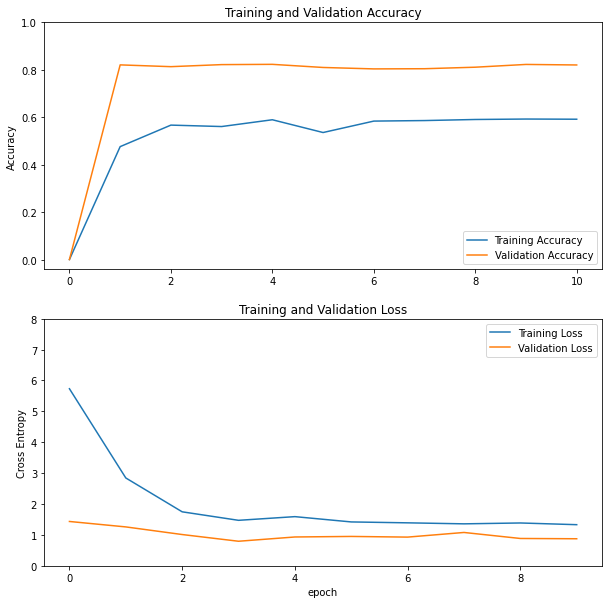

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,8.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
preds = model.evaluate(validation_dataset)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

84/84 [==============================] - 25s 299ms/step - loss: 0.8831 - accuracy: 0.8209
Loss = 0.8831340074539185
Test Accuracy = 0.8209179639816284


In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
img_path = '/content/drive/MyDrive/IMG_5196.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
plt.imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))
print("Emotion:", class_name[np.argmax(prediction)])